# lab5: gaussian_process_regression_2 
## Dano Gillam

In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg as la
import pandas as pd
from numba import jit, double, int_
import time
%matplotlib inline

### My Kernals

In [2]:
#kernals

#compare weekdays
@jit
def weekday_kernel(x,y):
    '''x,y (int 1 to 7), 7 is sunday'''
    return np.array([[1,.5,.25,.25,.5,0,0],[.5,1,.5,.25,.25,0,0],[.25,.5,1,.5,.25,0,0],[.25,.25,.5,1,.5,0,0],[.5,.25,.25,.5,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])[x-1,y-1]

@jit
def date_kernel(x,y):
    #expected that we formated our date as an integer day of the year
    x,y = np.exp(2*np.pi*1j*x/365.),np.exp(2*np.pi*1j*y/365.)
    return 1-np.sqrt((x.real-y.real)**2+(x.imag-y.imag)**2)

def bool_kernel(x,y):
    return abs(x-y)

def linear_kernel(x,y,highval=1000):
    return 1-np.abs(x-y)/highval


'''Composite kernels'''
def sum_kernels(x,y,listofkernels):
    out = 0
    for kern in listofkernels:
        out += kern(x,y)
    return out
    

### create K matrix

In [3]:
def get_K(x,y,kernal):
    #Args: k(a kernal function), x (a set of data)
    #Returns: K :a covariance matrix
    N = x.shape[0]
    M = y.shape[0]
    K = np.ones((N,M))
    for row in xrange(N):
        for col in xrange(M):
            K[row,col]=kernal(x[row],y[col])  
    return np.array(K)



### format the data 
The data needs to be formatted so that it can be interpretted.

In [4]:
def format_rossman_data(datafile, predictors):

    rossman = pd.read_csv(datafile)  # index_col=0
    N = rossman.shape[0]  #1017209

    #format our date as an integer day of the year
    rossman['Date'] = pd.to_datetime(rossman['Date'])
    rossman['Date']=[date.timetuple().tm_yday for date in rossman['Date']]

    #school and open will encompass the data of Stateholiday and School holiday
    #add a column: School : 1 = school was held
    rossman['School'] = pd.Series(np.ones(N), index=rossman.index)
    rossman.loc[rossman.StateHoliday!='0','School'] = 0    #school closed on stateholidays
    rossman.loc[rossman.SchoolHoliday==0,'School'] = 0     #school closed on schoolholidays
    rossman.loc[rossman.DayOfWeek==6,'School'] = 0         #school closed on saturdays
    rossman.loc[rossman.DayOfWeek==7,'School'] = 0         #school closed on sundays
    #remove holiday columns since their information is in other places
    rossman.drop('StateHoliday', axis=1, inplace=True)
    rossman.drop('SchoolHoliday', axis=1, inplace=True)

    #fill nans with zeros. This is NOT the right thing to do. TODO find all nans and decide what they should be. (means)
    for field in predictors:
        rossman[field] = rossman[field].fillna(0)

    for p in predictors:
        rossman[p] = rossman[p].astype(np.int64)

    return rossman

### My first prediction
This prediction uses only the day of the week. It demonstrates the subset of regressors algorithm well though. The landmarks are selected randomly, as are the training points.

prediction1


/home/danogillam/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


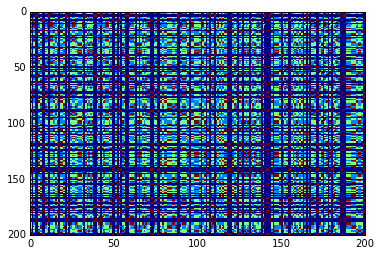

calculating inverse...
done
making prediction...
41087 /41087 
   Id       Sales
0   1  6096.05494
1   2  6096.05494
2   3  6096.05494
3   4  6096.05494
4   5  6096.05494
5   6  6096.05494
6   7  6096.05494
7   8  6096.05494
8   9  6096.05494
9  10  6096.05494


In [5]:
def prediction1(rossman,ross_test,var=.1):  
    #prediction using only DayOfWeek 
    
    n = 10000 #number of training points
    m = 200 #number of landmarks

    Xtests = ross_test['DayOfWeek'].values

    print 'prediction1'
    training = rossman.sample(n=n)
    landmark = rossman.sample(n=m) 
    trainingsales = training['Sales'].values
    trainingpoints  = training['DayOfWeek'].values
    landmarksales = landmark['Sales'].values
    landmarkpoints  = landmark['DayOfWeek'].values
    
    Knm = get_K(trainingpoints,landmarkpoints,weekday_kernel)
    Kmn = get_K(landmarkpoints,trainingpoints,weekday_kernel)
    Kmm = get_K(landmarkpoints,landmarkpoints,weekday_kernel)
    
    #plot heatmap
    plt.pcolormesh(Kmm) 
    plt.gca().invert_yaxis()
    plt.show()

    print 'calculating inverse...'
    Kinv = la.pinv(np.dot(Kmn,Knm)+var*Kmm)
    print 'done'
    print 'making prediction...'
    predictions = np.zeros((len(Xtests)))
    for t,xt in enumerate(Xtests): 
        print '\r',t,'/41087',
        Ktm = weekday_kernel(xt,landmarkpoints)
        mew_t = np.dot(Ktm,Kinv).dot(Kmn).dot(trainingsales)
        predictions[t] =  mew_t
    prediction = pd.DataFrame(columns=['Id','Sales'])
    prediction['Sales'] = predictions
    prediction['Id'] = ross_test['Id'].values
    prediction.to_csv('submission1',index=False)
    print '\n',prediction[:10]

predictors = ['DayOfWeek']
rossman = format_rossman_data('ross_train.csv',predictors)
ross_test = format_rossman_data('ross_test.csv',predictors)
prediction1(rossman,ross_test)


prediction1  
MSE = .84655  
ranking = 3244


### My second prediction
This prediction uses the day of the week and the date. The landmarks are selected randomly, as are the training points. It uses a weekday kernel and a date kernel composed using addition.

prediction2


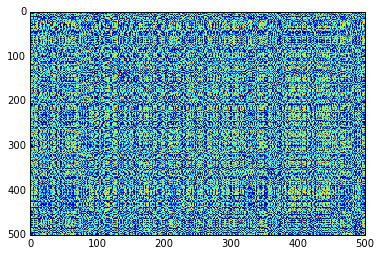

calculating inverse...
done
making prediction...
41087 /41087 
   Id        Sales
0   1  5597.961974
1   2  5597.961974
2   3  5597.961974
3   4  5597.961974
4   5  5597.961974
5   6  5597.961974
6   7  5597.961974
7   8  5597.961974
8   9  5597.961974
9  10  5597.961974


In [6]:
def prediction2(rossman,ross_test,var=.1,n=1000,m=500):  
    #prediction using only DayOfWeek and date
    
    n = n #number of training points
    m = m #number of landmarks

    Xtests = ross_test['DayOfWeek'].values

    print 'prediction2'
    training = rossman.sample(n=n)
    landmark = rossman.sample(n=m) 
    trainingsales = training['Sales'].values
    landmarksales = landmark['Sales'].values
    
    
    #Weekday Kernel
    trainingpoints  = training['DayOfWeek'].values
    landmarkpoints  = landmark['DayOfWeek'].values
    Knm = get_K(trainingpoints,landmarkpoints,weekday_kernel)
    Kmn = get_K(landmarkpoints,trainingpoints,weekday_kernel)
    Kmm = get_K(landmarkpoints,landmarkpoints,weekday_kernel)
    
    #add Date Kernel
    trainingpoints  = training['Date'].values
    landmarkpoints  = landmark['Date'].values
    Knm += get_K(trainingpoints,landmarkpoints,date_kernel)
    Kmn += get_K(landmarkpoints,trainingpoints,date_kernel)
    Kmm += get_K(landmarkpoints,landmarkpoints,date_kernel)
    
    #plot heatmap
    plt.pcolormesh(Kmm) 
    plt.gca().invert_yaxis()
    plt.show()
    
    #subset of regressors algorithm 
    print 'calculating inverse...'
    Kinv = la.pinv(np.dot(Kmn,Knm)+var*Kmm)
    print 'done'
    print 'making prediction...'
    predictions = np.zeros((len(Xtests)))
    for t,xt in enumerate(Xtests): 
        print '\r',t,'/41087',
        Ktm = weekday_kernel(xt,landmark['DayOfWeek'].values)
        Ktm += date_kernel(xt,landmark['Date'].values)
        mew_t = np.dot(Ktm,Kinv).dot(Kmn).dot(trainingsales)
        predictions[t] =  mew_t
        
    #format and save prediction
    prediction = pd.DataFrame(columns=['Id','Sales'])
    prediction['Sales'] = predictions
    prediction['Id'] = ross_test['Id'].values
    prediction.to_csv('submission2',index=False)
    print '\n',prediction[:10]

predictors = ['DayOfWeek']
rossman = format_rossman_data('ross_train.csv',predictors)
ross_test = format_rossman_data('ross_test.csv',predictors)
prediction2(rossman,ross_test)


prediction 2  
MSE = .50465  
rank = 3168

prediction2


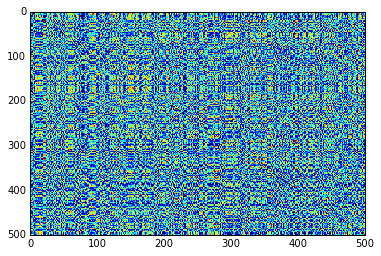

calculating inverse...
done
making prediction...
41087 /41087 
   Id        Sales
0   1  5634.217416
1   2  5634.217416
2   3  5634.217416
3   4  5634.217416
4   5  5634.217416
5   6  5634.217416
6   7  5634.217416
7   8  5634.217416
8   9  5634.217416
9  10  5634.217416
reg:  34.5764019489


In [7]:
predictors = ['DayOfWeek']
rossman = format_rossman_data('ross_train.csv',predictors)
ross_test = format_rossman_data('ross_test.csv',predictors)

start = time.time()
prediction2(rossman,ross_test)
print 'reg: ',time.time()-start

prediction2


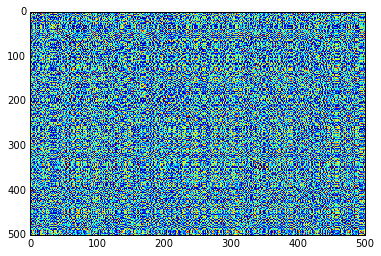

calculating inverse...
done
making prediction...
41087 /41087 
   Id       Sales
0   1  5046.52056
1   2  5046.52056
2   3  5046.52056
3   4  5046.52056
4   5  5046.52056
5   6  5046.52056
6   7  5046.52056
7   8  5046.52056
8   9  5046.52056
9  10  5046.52056
jit:  31.5012691021


In [8]:
predictors = ['DayOfWeek']
rossman = format_rossman_data('ross_train.csv',predictors)
ross_test = format_rossman_data('ross_test.csv',predictors)

start = time.time()
prediction2(rossman,ross_test)
print 'jit: ',time.time()-start

In [9]:
@jit
def prediction2jit(rossman,ross_test,var=.1,n=1000,m=500):  
    #prediction using only DayOfWeek and date
    
    n = n #number of training points
    m = m #number of landmarks

    Xtests = ross_test['DayOfWeek'].values

    print 'prediction2'
    training = rossman.sample(n=n)
    landmark = rossman.sample(n=m) 
    trainingsales = training['Sales'].values
    landmarksales = landmark['Sales'].values
    
    
    #Weekday Kernel
    trainingpoints  = training['DayOfWeek'].values
    landmarkpoints  = landmark['DayOfWeek'].values
    Knm = get_K(trainingpoints,landmarkpoints,weekday_kernel)
    Kmn = get_K(landmarkpoints,trainingpoints,weekday_kernel)
    Kmm = get_K(landmarkpoints,landmarkpoints,weekday_kernel)
    
    #add Date Kernel
    trainingpoints  = training['Date'].values
    landmarkpoints  = landmark['Date'].values
    Knm += get_K(trainingpoints,landmarkpoints,date_kernel)
    Kmn += get_K(landmarkpoints,trainingpoints,date_kernel)
    Kmm += get_K(landmarkpoints,landmarkpoints,date_kernel)
    
    #plot heatmap
    plt.pcolormesh(Kmm) 
    plt.gca().invert_yaxis()
    plt.show()
    
    #subset of regressors algorithm 
    Kinv = la.pinv(np.dot(Kmn,Knm)+var*Kmm)
    predictions = np.zeros((len(Xtests)))
    for t,xt in enumerate(Xtests): 
        Ktm = weekday_kernel(xt,landmark['DayOfWeek'].values)
        Ktm += date_kernel(xt,landmark['Date'].values)
        mew_t = np.dot(Ktm,Kinv).dot(Kmn).dot(trainingsales)
        predictions[t] =  mew_t
        
    #format and save prediction
    prediction = pd.DataFrame(columns=['Id','Sales'])
    prediction['Sales'] = predictions
    prediction['Id'] = ross_test['Id'].values
    prediction.to_csv('submission2',index=False)

prediction2



/home/danogillam/anaconda2/lib/python2.7/site-packages/numba/dataflow.py:297: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


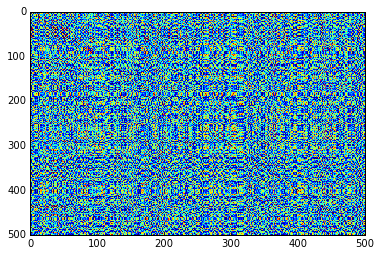

jit:  26.9961309433


In [10]:
    
predictors = ['DayOfWeek']
rossman = format_rossman_data('ross_train.csv',predictors)
ross_test = format_rossman_data('ross_test.csv',predictors)

start = time.time()
prediction2jit(rossman,ross_test)
print 'jit: ',time.time()-start